# Molecular Dynamics

We have introduced the classical potential models, and have derived and showen some of their basic properties.
Now we can use these potential models to look at the dynamics of the system. 

## Force and acceleration
The particles that we study are classical in nature, therefore we can apply classical mechanics to rationalise their dynamic behaviour. 
For this the starting point is **Newton's second law of motion**, 

$$ \mathbf{f} = m\mathbf{a}, $$

where $\mathbf{f}$ is the force vector on an atom of mass, $m$, with an acceleration vector, $\mathbf{a}$. 
The force, $f$, between two particles, at a position $r$, can be found from the interaction energy, $E(r)$, 

$$ f = \dfrac{-\partial E(r)}{\partial r}.$$

Which is to say that the force is the negative of the first derivative of the energy with respect to the postion of the particles.
The Python code below creates a new function that is capable of calculating the force from the Lennard-Jones potential. 
The force on the atoms is then plotted.

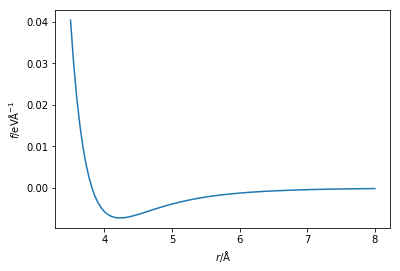

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def lj_force(r, epsilon, sigma):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the force of the interaction.
    
    Parameters
    ----------
    r: float
        Distance between two particles (Å)
    epsilon: float 
        Potential energy at the equilibrium bond 
        length (eV)
    sigma: float 
        Distance at which the potential energy is 
        zero (Å)
    
    Returns
    -------
    float
        Force of the van der Waals interaction (eV/Å)
    """
    return 48 * epsilon * np.power(
        sigma, 12) / np.power(
        r, 13) - 24 * epsilon * np.power(
        sigma, 6) / np.power(r, 7)
    
r = np.linspace(3.5, 8, 100)
plt.plot(r, lj_force(r, 0.0103, 3.4))
plt.xlabel(r'$r$/Å')
plt.ylabel(r'$f$/eVÅ$^{-1}$')
plt.show()

You may have noticed that in Newton's second law of motion, the force is a vector quantity, whereas the first negative derivative of the energy is a scalar.
Therefore, it is important that we determine the force in each direction for our simulation.
This is achieved by multiplication by the unit vector in that direction,

$$ \mathbf{f}_x = f\hat{\mathbf{r}}_x\text{, where }\hat{\mathbf{r}}_x = \dfrac{r_x}{|\mathbf{r}|}. $$

In the above equation, $r_x$ is the distance between the two particles in the $x$-dimension and $|\mathbf{r}|$ is the magnitude of the distance vector. 
For simplicity, we will initially **only** consider particles interacting in a one-dimensional space. 

The Python code below shows how to determine the acceleration on each atom of argon due to each other atom of argon. 
It is possible to **increase the efficiency** of this algorithm by applying Newton's third law, e.g. the force on atom $i$ will be equal and opposite to the force on atom $j$. 

In [5]:
mass_of_argon = 39.948 # amu

def get_accelerations(positions):
    """
    Calculate the acceleration on each 
    particle as a  result of each other 
    particle. 
    N.B. We use the Python convention of
    numbering from 0.
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, 
        for all of the particles (Å)
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle (eV/Åamu)
    """
    accel_x = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size - 1):
        for j in range(i + 1, positions.size):
            r_x = positions[j] - positions[i]
            rmag = np.sqrt(r_x * r_x)
            force_scalar = lj_force(rmag, 0.0103, 3.4)
            force_x = force_scalar * r_x / rmag
            accel_x[i, j] = force_x / mass_of_argon #eV Å-1 amu-1
            # appling Newton's third law
            accel_x[j, i] = - force_x / mass_of_argon
    return np.sum(accel_x, axis=0)

accel = get_accelerations(np.array([1, 5, 10]))
print('Acceleration on particle 0 = {:.3e} eV/Åamu'.format(
    accel[0]))
print('Acceleration on particle 1 = {:.3e} eV/Åamu'.format(
    accel[1]))
print('Acceleration on particle 2 = {:.3e} eV/Åamu'.format(
    accel[2]))

Acceleration on particle 0 = 1.453e-04 eV/Åamu
Acceleration on particle 1 = -4.519e-05 eV/Åamu
Acceleration on particle 2 = -1.002e-04 eV/Åamu


## Integration

Now that we have seen how to obtain the acceleration on our particles, we can apply the **Newtonian equations of motion** to probe the particles trajectory, 

$$ \mathbf{x}_i(t + \Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \dfrac{1}{2} \mathbf{a}_i(t)\Delta t^2, $$

$$ \mathbf{v}_i(t + \Delta t) = \mathbf{v}_i(t) + \dfrac{1}{2}\big[\mathbf{a}_i(t) + \mathbf{a}_i(t+\Delta t)\big]\Delta t, $$ 

where, $\Delta t$ is the timestep (how far in time is incremented), $\mathbf{x}_i$ is the particle position, $\mathbf{v}_i$ is the velocity, and $\mathbf{a}_i$ the acceleration. 
This pair of equations is known as the Velocity-Verlet algorithm, which can be written as:

1. Calculate the force (and therefore acceleration) on the particle
2. Determine a new velocity for the particle, based on the average acceleration at the current and new positions
3. Overwrite the old acceleration values with the new ones, $\mathbf{a}_i(t) = \mathbf{a}_i(t+\Delta t)$
4. Find the position of the particle after some timestep
5. Go to 1

After the initial relaxation of the particles to equilibrium, this process can be continued for as long as is required to get **good statistics** for the quantity you are intereseting in. 

The Python code below is a set of two function for the above equations, these will be applied later.

In [6]:
def update_pos(x, v, a, dt):
    """
    Update the particle positions.
    
    Parameters
    ----------
    x: ndarray of floats
        The positions of the particles in a 
        single dimension (Å)
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension (eV/Åamu)
    dt: float
        The timestep length (s)
    
    Returns
    -------
    ndarray of floats:
        New positions of the particles in a 
        single dimension (Å)
    """
    return x + v * dt + 0.5 * a * dt * dt

def update_velo(v, a, a1, dt):
    """
    Update the particle velocities.
    
    Parameters
    ----------
    v: ndarray of floats
        The velocities of the particles in a 
        single dimension (eVs/Åamu)
    a: ndarray of floats
        The accelerations of the particles in a 
        single dimension at the previous 
        timestep (eV/Åamu)
    a1: ndarray of floats
        The accelerations of the particles in a 
        single dimension at the current 
        timestep (eV/Åamu)
    dt: float
        The timestep length (s)
    
    Returns
    -------
    ndarray of floats:
        New velocities of the particles in a 
        single dimension (eVs/Åamu)
    """
    return v + 0.5 * (a + a1) * dt

The above process is called the intergration step, and Velocity-Verlet is the **integrator**. 
This function is highly non-linear for more than two particles. 
The result is that the integration step will only be valid for very small values of $\Delta t$, e.g. if a large timestep is used the acceleration calculated will not be accurate as the forces on the atom will change too significantly during it. 
The value for the timestep is usually on the order of 10<sup>-15</sup> s (femtoseconds). 
So in order to measure a nanosecond of "real-time" molecular dynamics, 1&nbsp;000&nbsp;000 (one million) iterations of the above algorithm must be performed. 
This can be very slow for large, realistic systems.

## Initialisation

There are only **two components** left that we need to run a molecular dynamics simulation, and both are associated with the original configuration of the system; the original particle positions, and the original particle velocities. 

The particle positions are usually either taken from some library of structures (e.g. the [protein data bank](http://www.rcsb.org) if you are simulating proteins) or based on some knowledge of the system (e.g. CaF<sub>2</sub> is well known to have a face-centred cubic structure). 
For complex, multicomponent systems, software such as Packmol [[1](#References)] may be used to build up the structure from its constituent parts.
The importance of this initial structure **cannot be overstated**.
For example if the initial structure is uinrepresentative of the equilibrium structure, it may take a very long time before the equilibrium structure is obtained, possibly much longer than can be reasonably simulated. 

The particle velocities are more general, as the total kinetic energy, $E_K$ of the system (and therefore the particle velocities) are dependent on the temperature of the simulation, $T$. 

$$ E_K = \sum_{i=1}^N \dfrac{m_i|v_i|^2}{2} = \dfrac{3}{2}Nk_BT, $$

where, $m_i$ is the mass of particle $i$, $N$ is the number of particles, and $k_B$ is the Boltzmann constant. 
A common method to initialise the velocities is implemented in the Python function below. 

In [7]:
from scipy.constants import Boltzmann

def init_velocity(T, number_of_particles):
    """
    Initialise the velocities for a series 
    of particles.
    
    Parameters
    ----------
    T: float
        Temperature of the system at 
        initialisation (K)
    number_of_particles: int
        Number of particles in the 
        system
    
    Returns
    -------
    ndarray of floats
        Initial velocities for a series of 
        particles (eVs/Åamu)
    """
    R = np.random.rand(number_of_particles) - 0.5
    return R * np.sqrt(Boltzmann * T / (mass_of_argon * 1.602e-19))

## References

1. Martínez, L.; Andrade, R.; Birgin, E. G.; Martínez, J. M. *J. Comput. Chem.* 2009, **30** (13), 2157–2164. [10.1002/jcc.21224](https://doi.org/10.1002/jcc.21224).
